# Polarization reconstruction debugging (almost there!!)

### Sep 28, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize

Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
# mpl.rcParams['mathtext.rm'] = 'Times New Roman'
# mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
# mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# mpl.rc('font', family='serif', size=12)
# mpl.rcParams['xtick.labelsize'] = 14
# mpl.rcParams['ytick.labelsize'] = 14
# mpl.rcParams['xtick.major.size'] = 5
# mpl.rcParams['ytick.major.size'] = 5

# mpl.rcParams['axes.titlesize'] = 18
# mpl.rcParams['axes.labelsize'] = 18
# # mpl.rc('font', size=16)
# mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Define function

In [3]:
def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
#     np.random.seed(9)
    phi = np.random.uniform(0,2*np.pi)
    costheta = np.random.uniform(-1,1)

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = costheta
    return np.array([x,y,z])

In [4]:
# phi = np.deg2rad(90)
# theta = np.deg2rad(90)
from scipy import signal
pol_ev = np.array([0.,0,1])
dirProp = np.array([1,0,0])
# pol_ev = np.array([0.73464503,0.66096714,0.15303304])
# dirProp = np.array([0.12301928,0.09204764,0.98812625])

# dirProp = random_three_vector()
phi = np.arctan2(dirProp[1],dirProp[0])
print("phi:%0.2f"%phi)
theta = np.arccos(dirProp[2])
print("theta:%0.2f"%np.degrees(theta))

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")

sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
output = antV.front_end(sig)

timeV = output.times*1E9 #in ns
voltageV = output.values*1E3 #in mV

phi:0.00
theta:90.00


In [5]:
# plt.plot(sigH.times, sig.values)

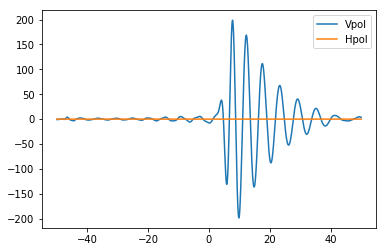

In [6]:
sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
antH.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
outputH = antH.front_end(sigH)
timeH = outputH.times*1E9 #in ns
voltageH = outputH.values*1E3 #in mV

plt.plot(timeV,voltageV, label="Vpol")
plt.plot(timeH,voltageH, label="Hpol")
plt.legend()

Text(0,0.5,'Voltage [mV]')

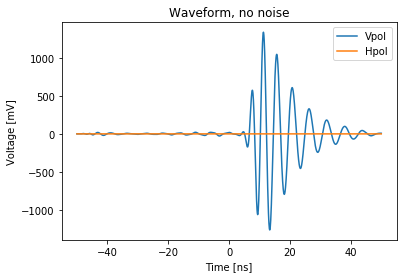

In [7]:
deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)
plt.plot(deConv_V_t,deConv_V_v, label = "Vpol")
plt.plot(deConv_H_t,deConv_H_v, label = "Hpol")
plt.legend()
plt.title("Waveform, no noise")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]")


### Calculate polarization angle from Stokes parameters

In [8]:
def PolAngleStokes(Hpol,Vpol):
    return np.degrees(0.5*np.arctan2(2*Hpol*Vpol,(Hpol**2-Vpol**2)))

In [9]:
PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))

90.0

In [10]:
abs(np.degrees(np.pi/2-np.arccos(pol_ev[2])))

90.0

In [11]:
def PolRatio(Hpol,Vpol):
    return np.degrees(np.arctan(Hpol/Vpol))

In [12]:
def findMaxAmp(voltage):
    if(abs(max(voltage))>=abs(min(voltage))):
        maxAmp = max(voltage)
    else:
        maxAmp = min(voltage)
    return maxAmp

# Generate random polarizations

In [16]:
reco=[]
true=[]
phi_ = []
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, -100), power_threshold=0)
antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, -100), power_threshold=0)
# antV.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))
# antH.set_orientation(z_axis=(0, 0, 1), x_axis=(1, 0, 0))

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")
for count in range(0,10000):
#     dirProp = np.array([1/np.sqrt(2),0,1/np.sqrt(2)])
    dirProp =  random_three_vector()
    pol_ev = np.random.randn(3)  # take a random vector
    pol_ev -= pol_ev.dot(dirProp) * dirProp       # make it orthogonal to k
    pol_ev /= np.linalg.norm(pol_ev) 
    
    _, theta, phi = antV.antenna._convert_to_antenna_coordinates(antV.position - normalize(dirProp))
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos(theta)
    newdirProp = np.array([x,y,z])
    y_axis = np.cross(antV.antenna.z_axis, antV.antenna.x_axis)
    transformation = np.array([antV.antenna.x_axis, y_axis, antV.antenna.z_axis])
    ant_pol = np.dot(transformation, normalize(pol_ev))
#     pol_ev2 = np.random.randn(3)  # take a random vector
#     pol_ev2 -= pol_ev.dot(newdirProp) * newdirProp       # make it orthogonal to k
#     pol_ev2 /= np.linalg.norm(pol_ev2) 
#     phi = np.arctan2(dirProp[1],dirProp[0])
#     theta = np.arccos(dirProp[2])
#     pol_ev = random_three_vector()
    
    sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
    sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
    output = antV.front_end(sig)

    timeV = output.times*1E9 #in ns
    voltageV = output.values*1E3 #in mV

    sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

    sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
    outputH = antH.front_end(sigH)
    timeH = outputH.times*1E9 #in ns
    voltageH = outputH.values*1E3 #in mV

    deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
    deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)
    reco_ = PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))
    true_ = abs(np.degrees(np.pi/2-np.arccos(ant_pol[2])))
#     if(reco_-true_>100):
# # #         continue
# # #         true_=abs(90-true_)
#     if(reco_-abs(true_))>70:
#     if(reco_)<5:
# #         continue
#         print("dir_prop:%s"%newdirProp)
#         print("pol_vec:%s"%ant_pol)
#         print("theta_prop:%0.3f"%np.degrees(theta))
#         print("theta_reco:%0.3f"%reco_)
#         print("theta_true:%0.3f"%true_)
#         print(np.degrees(np.arccos(pol_ev[2])))
#         print("Dot product is %f"%np.dot(newdirProp,ant_pol))
# #         plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
# #         plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
#         plt.figure()
#         plt.plot(timeV,voltageV,label="Vpol")
#         plt.plot(timeH,voltageH, label="Hpol")
#         plt.legend()
#         plt.figure()
#         plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
#         plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
#         plt.legend()
#         break
    reco.append(reco_)
    true.append(true_)
    phi_.append(np.degrees(phi))
#     print((PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))-np.degrees(theta)))

In [17]:
reco=np.array(reco)
true=np.array(true)
phi_=np.array(phi_)

# dist = pd.DataFrame({"reco":reco, "true":true})
# dist.head()
# gt90 = dist.loc[dist.true>0]
# lt90 = dist.loc[dist.true<=0]

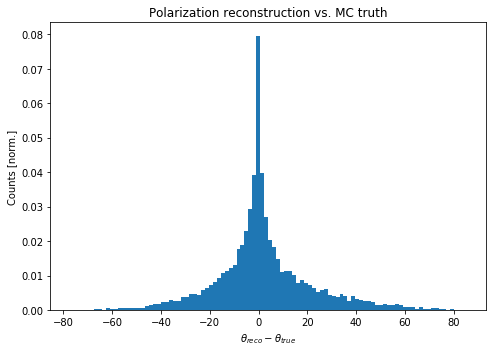

In [18]:
plt.figure(figsize=(7,5))
plt.hist(reco-abs(true), bins=100, density=True, alpha=1,label="");

plt.xlabel("$\\theta_{reco}-\\theta_{true}$")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
plt.tight_layout()
# plt.legend()

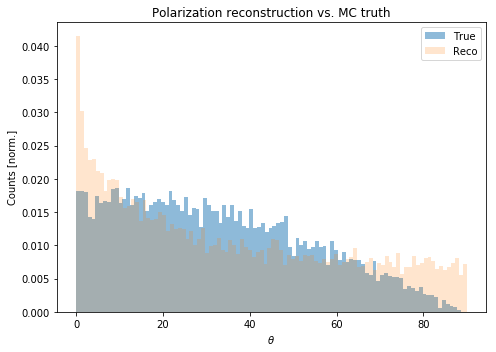

In [19]:
plt.figure(figsize=(7,5))
plt.hist(true, bins=100, density=True, alpha=0.5,label="True");
plt.hist(reco, bins=100, density=True, alpha=0.2,label="Reco");

# plt.xlabel("$\\theta_{reco}-abs(\\theta_{true})$")
plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
plt.tight_layout()
plt.legend()
plt.show()

# plt.savefig("./plots/Stokes/recoVsTrue_MC_abs.png", dpi=200)

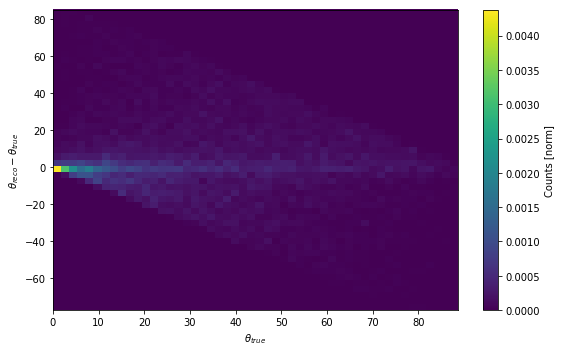

In [20]:
plt.figure(figsize=(8,5))
plt.hist2d(true,reco-true, bins=50, normed=True);
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$")
plt.tight_layout()
# plt.ylim(-10,10)
# plt.savefig("./plots/Stokes/recovsRecoMinusTrue.pdf")

In [21]:
dist = pd.DataFrame({"reco":reco, "true":true, "phi":phi_})
dist.head()

,reco,true,phi
0,32.593868,45.464668,315.996426
1,60.900956,26.277339,243.090606
2,0.510544,0.602316,241.039004
3,74.916460,65.579691,47.557830
4,24.347170,65.472115,27.008775


Text(0.5,0,'$\\phi$')

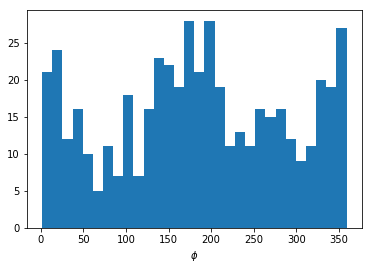

In [26]:
tail = dist.loc[(dist.reco-dist.true)>40]
# plt.hist(phi_)
plt.hist(tail.phi, bins=30);
plt.xlabel("$\phi$")

Text(0.5,0,'$\\phi$')

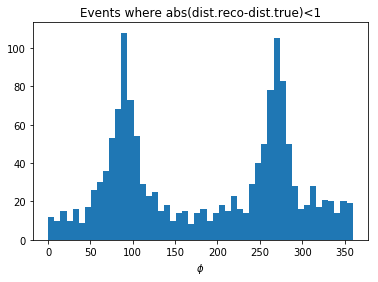

In [23]:
center = dist.loc[abs(dist.reco-dist.true)<1]
plt.title("Events where abs(dist.reco-dist.true)<1")
plt.hist(center.phi, bins=50);
plt.xlabel("$\phi$")

Text(0.5,0,'$\\phi$')

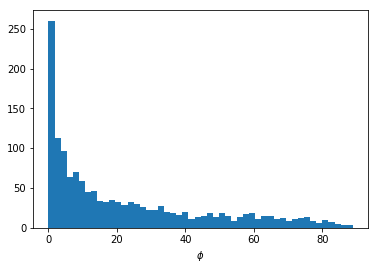

In [24]:
plt.hist(center.reco, bins=50);
plt.xlabel("$\phi$")

In [ ]:

deltaTheta=[]
deltaPhi=[]
for count in range(0,10000):

    dirProp =  random_three_vector()
    pol_ev = np.random.randn(3)  # take a random vector
    pol_ev -= pol_ev.dot(dirProp) * dirProp       # make it orthogonal to k
    pol_ev /= np.linalg.norm(pol_ev) 

    phi = np.arctan2(dirProp[1],dirProp[0])
    theta = np.arccos(dirProp[2])
    # print(np.degrees(phi))
    # print(np.degrees(theta))
    _, direction_theta, direction_phi = antV.antenna._convert_to_antenna_coordinates(antV.position - normalize(dirProp))
    # print(np.degrees(direction_phi))
    # print(np.degrees(direction_theta))
    deltaTheta.append(np.degrees(theta))
    deltaPhi.append(np.degrees(phi))

In [ ]:
plt.hist(abs(np.array(deltaTheta)),bins=100);

In [ ]:
pickle = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/pol_quant_debug.pkl")

In [ ]:
pickle.head()

In [ ]:
plt.hist(pickle.phi_reco,bins=50);

In [ ]:
plt.hist(np.degrees(np.arccos(pickle.pol_z)), bins=50);

In [ ]:
plt.hist(pickle.AngStokes-np.degrees(np.arctan(abs(pickle.pol_z))),bins=100);

In [ ]:
pickle.pol_x**2+pickle.pol_y**2+pickle.pol_z**2

In [38]:
costheta = [np.random.uniform(-1,1) for i in range(0,1000)]


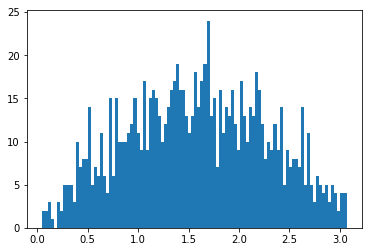

In [46]:
plt.hist(np.arccos(costheta), bins=100);

In [ ]:
d=(sin_t*cos_t, )